In [16]:
import gensim

spelling_model = gensim.models.KeyedVectors.load_word2vec_format('spellingCorrection_model/bnword2vec.txt')

In [3]:
from models import resnet34
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet34.resnet34().to(device)

# Load the trained weights
model.load_state_dict(torch.load('recongnition_model\char_level_trained_model_128x224_shoroborno_again.pth'))

<All keys matched successfully>

In [4]:
from PIL import Image
import os

def convert_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of all files in the input folder
    files = os.listdir(input_folder)

    for file in files:
        # Check if the file is an image (you may want to add more file format checks)
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', 'bmp')):
            # Construct the full path of the input file
            input_path = os.path.join(input_folder, file)

            # Open the image using Pillow
            original_image = Image.open(input_path)

            # Convert the image according to the specified requirements
            converted_image = original_image.convert('RGB')
            converted_image = converted_image.resize((640, 640))

            # Save the converted image in the output folder with the same filename and '.jpg' extension
            output_path = os.path.join(output_folder, os.path.splitext(file)[0] + '.jpg')
            converted_image.save(output_path, 'JPEG', quality=95)

if __name__ == "__main__":
    # Specify the input and output folders
    input_folder = 'handw_s_demo'
    output_folder = 'handw_s_demo_test'

    # Perform the image conversion
    convert_images(input_folder, output_folder)


In [5]:
!yolo task=detect mode=predict model=detection_model/weights2/last_medium.pt conf=0.5 source='handw_s_demo_test' save_txt=True
#last medium is the last.pt of the medium yolov8 model 
# this is downloaded from the model trained on kaggel
#change the path to runs/detect/train/weights/best.pt

Ultralytics YOLOv8.0.225 🚀 Python-3.11.4 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\1.jpg: 640x640 4 Characterss, 25.1ms
image 2/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\2.jpg: 640x640 3 Characterss, 25.2ms
image 3/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\3.jpg: 640x640 5 Characterss, 25.5ms
image 4/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\4.jpg: 640x640 2 Characterss, 24.4ms
image 5/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\5.jpg: 640x640 3 Characterss, 24.7ms
image 6/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\6.jpg: 640x640 4 Characterss, 23.8ms
image 7/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\7.jpg: 640x640 4 Characterss, 21.0ms
image 8/9 e:\BanglaHandwrittenWord_detection\handw_s_demo_test\8.jpg: 640x640 5 Characterss, 20.3ms
ima

In [6]:
import os
import csv
from collections import defaultdict

# Path to the directory containing the txt files
labels_directory = 'runs/detect/predict/labels'

# Output CSV file
csv_file_path = 'handw_s_demo_annotations.csv'

# Initialize a defaultdict to store lists for each image_id
data_dict = defaultdict(lambda: {'x_center': [], 'y_center': [], 'width': [], 'height': []})

# Iterate over txt files in the directory
for filename in os.listdir(labels_directory):
    if filename.endswith(".txt"):
        # Extract image_id from the filename
        image_id = filename.split('.txt')[0]

        # Read the content of the txt file
        with open(os.path.join(labels_directory, filename), 'r') as file:
            lines = file.readlines()

        # Parse each line and aggregate information
        for line in lines:
            parts = line.strip().split(' ')
            _, x_center, y_center, width, height = map(float, parts)

            # Append information to lists in the defaultdict
            data_dict[image_id]['x_center'].append(x_center)
            data_dict[image_id]['y_center'].append(y_center)
            data_dict[image_id]['width'].append(width)
            data_dict[image_id]['height'].append(height)

# Write data to CSV file
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['image_id', 'x_center', 'y_center', 'width', 'height']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Write header
    writer.writeheader()

    # Write data rows
    for image_id, data in data_dict.items():
        writer.writerow({
            'image_id': image_id,
            'x_center': data['x_center'],
            'y_center': data['y_center'],
            'width': data['width'],
            'height': data['height']
        })

print(f"CSV file '{csv_file_path}' created successfully.")


CSV file 'handw_s_demo_annotations.csv' created successfully.


In [7]:
import csv
import numpy as np
import ast

# Specify the paths to your input and output CSV files
input_csv_path = 'handw_s_demo_annotations.csv'
output_csv_path = 'handw_s_demo_sorted_annotations.csv'

# Open the input CSV file
with open(input_csv_path, 'r') as input_csv_file:
    # Create a CSV reader object with header
    csv_reader = csv.DictReader(input_csv_file)

    # Extract and sort data
    rows = []
    for row in csv_reader:
        image_id = row['image_id']
        x_c = ast.literal_eval(row['x_center'])
        y_c = ast.literal_eval(row['y_center'])
        w = ast.literal_eval(row['width'])
        h = ast.literal_eval(row['height'])

        # Sort the data based on x_center
        sorted_bundle = sorted(zip(x_c, y_c, w, h), key=lambda bundle: bundle[0])
        sorted_x, sorted_y, sorted_w, sorted_h = zip(*sorted_bundle)

        # Create a new row with sorted values
        new_row = {
            'image_id': image_id,
            'x_center': str(sorted_x),
            'y_center': str(sorted_y),
            'width': str(sorted_w),
            'height': str(sorted_h)
        }

        # Append the new row to the list
        rows.append(new_row)

# Write the sorted data to a new CSV file
fieldnames = ['image_id', 'x_center', 'y_center', 'width', 'height']

with open(output_csv_path, 'w', newline='') as output_csv_file:
    csv_writer = csv.DictWriter(output_csv_file, fieldnames=fieldnames)

    # Write the header
    csv_writer.writeheader()

    # Write the sorted rows
    csv_writer.writerows(rows)

print(f"Sorted data saved to {output_csv_path}")


Sorted data saved to handw_s_demo_sorted_annotations.csv


In [8]:
def calculate_coordinates(x_center, y_center, width, height):
    # Calculate half-width and half-height
    half_width = width / 2
    half_height = height / 2

    # Calculate the four coordinates
    x1 = x_center - half_width
    y1 = y_center - half_height
    x3 = x_center + half_width
    y3 = y_center + half_height

    return x1, y1, x3, y3

In [9]:
import pandas as pd
import os
import ast

def image_patch(path, wid=640, hei=640, csv_path= 'handw_s_demo_sorted_annotations.csv'):

    # Split the path using '/' and get the last part
    filename = os.path.split(path)[-1]

    if(filename.split('.')[0].isdigit()):
        image_id_to_find = ''.join(c for c in filename if c.isdigit())
    else:
        image_id_to_find = filename.split('_')[0]


    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Find the rows with the specified image_id
    matching_rows = df[df['image_id'] == int(image_id_to_find)]

    # Check if there are any matching rows
    if not matching_rows.empty:
        # Extract the first matching row
        row = matching_rows.iloc[0]

        # Continue with the rest of your code...
        x_c = ast.literal_eval(row['x_center'])
        y_c = ast.literal_eval(row['y_center'])
        w = ast.literal_eval(row['width'])
        h = ast.literal_eval(row['height'])

        # Rest of your code...
    else:
        print(f"No matching rows found for image_id {image_id_to_find}")
        print(df)

    x_c = [x * wid for x in x_c]
    y_c = [y * hei for y in y_c]
    w = [width * wid for width in w]
    h = [height * hei for height in h]

    patches = []
    img_np = np.array(image)

    for i in range(len(x_c)):
        # Coordinates for each character
        xc, yc, width, height = x_c[i], y_c[i], w[i], h[i]

        # Calculate other coordinates
        x1, y1, x3, y3 = calculate_coordinates(xc, yc, width, height)

        x1, y1, x3, y3 = int(x1), int(y1), int(x3), int(y3)

        patch = img_np[y1:y3,x1:x3]
        #plt.imshow(patch,cmap='gray')
        #plt.show()
        patches.append(patch)

    return patches


In [10]:
grapheme_root_components = ['০','১','২','৩','৪','৫','৬','৭','৮','৯','ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'ক্ক', 'ক্ট', 'ক্ত', 'ক্ল', 'ক্ষ', 'ক্ষ্ণ', 'ক্ষ্ম', 'ক্স', 'খ', 'গ', 'গ্ধ', 'গ্ন', 'গ্ব', 'গ্ম', 'গ্ল', 'ঘ', 'ঘ্ন', 'ঙ', 'ঙ্ক', 'ঙ্ক্ত', 'ঙ্ক্ষ', 'ঙ্খ', 'ঙ্গ', 'ঙ্ঘ', 'চ', 'চ্চ', 'চ্ছ', 'চ্ছ্ব', 'ছ', 'জ', 'জ্জ', 'জ্জ্ব', 'জ্ঞ', 'জ্ব', 'ঝ', 'ঞ', 'ঞ্চ', 'ঞ্ছ', 'ঞ্জ', 'ট', 'ট্ট', 'ঠ', 'ড', 'ড্ড', 'ঢ', 'ণ', 'ণ্ট', 'ণ্ঠ', 'ণ্ড', 'ণ্ণ', 'ত', 'ত্ত', 'ত্ত্ব', 'ত্থ', 'ত্ন', 'ত্ব', 'ত্ম', 'থ', 'দ', 'দ্ঘ', 'দ্দ', 'দ্ধ', 'দ্ব', 'দ্ভ', 'দ্ম', 'ধ', 'ধ্ব', 'ন', 'ন্জ', 'ন্ট', 'ন্ঠ', 'ন্ড', 'ন্ত', 'ন্ত্ব', 'ন্থ', 'ন্দ', 'ন্দ্ব', 'ন্ধ', 'ন্ন', 'ন্ব', 'ন্ম', 'ন্স', 'প', 'প্ট', 'প্ত', 'প্ন', 'প্প', 'প্ল', 'প্স', 'ফ', 'ফ্ট', 'ফ্ফ', 'ফ্ল', 'ব', 'ব্জ', 'ব্দ', 'ব্ধ', 'ব্ব', 'ব্ল', 'ভ', 'ভ্ল', 'ম', 'ম্ন', 'ম্প', 'ম্ব', 'ম্ভ', 'ম্ম', 'ম্ল', 'য', 'র', 'ল', 'ল্ক', 'ল্গ', 'ল্ট', 'ল্ড', 'ল্প', 'ল্ব', 'ল্ম', 'ল্ল', 'শ', 'শ্চ', 'শ্ন', 'শ্ব', 'শ্ম', 'শ্ল', 'ষ', 'ষ্ক', 'ষ্ট', 'ষ্ঠ', 'ষ্ণ', 'ষ্প', 'ষ্ফ', 'ষ্ম', 'স', 'স্ক', 'স্ট', 'স্ত', 'স্থ', 'স্ন', 'স্প', 'স্ফ', 'স্ব', 'স্ম', 'স্ল', 'স্স', 'হ', 'হ্ন', 'হ্ব', 'হ্ম', 'হ্ল', 'ৎ', 'ড়', 'ঢ়', 'য়']
vowel_diacritic_components = ['0', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ']
consonant_diacritic_components = ['0', 'ঁ', 'র্', 'র্য', '্য', '্র', '্র্য', 'র্্র']

In [11]:
from torchvision import transforms
from PIL import Image, ImageOps, ImageEnhance

def detect(patches):
    predicted = []
    for patch in patches:
        img = Image.fromarray(patch)
        enhancer = ImageEnhance.Contrast(img)
        img_enhanced = enhancer.enhance(2.0)
        img_inv = ImageOps.invert(img_enhanced)
        img_inv = img_inv.resize((224,128)).convert('RGB')

        transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)) 
                ])

        img_ten = transform(img_inv)

        input_image = img_ten.unsqueeze(0) 

        input_image = input_image.to(device)

        model.eval()

        # Forward pass to get model predictions
        with torch.no_grad():
            outputs = model(input_image)

        # Find the index of the maximum probability for each class
        predicted_grapheme_idx = torch.argmax(outputs[0]).item()
        predicted_vowel_idx = torch.argmax(outputs[1]).item()
        predicted_consonant_idx = torch.argmax(outputs[2]).item()

        predicted_grapheme_root = torch.tensor(predicted_grapheme_idx)
        predicted_vowel_diacritic = torch.tensor(predicted_vowel_idx)
        predicted_consonant_diacritic = torch.tensor(predicted_consonant_idx)

        pred_char = []

        if(predicted_vowel_idx != 0 and predicted_consonant_idx != 0):
                if(predicted_consonant_idx == 2):
                    pred_char.append( consonant_diacritic_components[predicted_consonant_idx] +  grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx] )
                elif(predicted_consonant_idx == 1):
                    pred_char.append(grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx] + consonant_diacritic_components[predicted_consonant_idx])
                else:
                    pred_char.append(grapheme_root_components[predicted_grapheme_idx] + consonant_diacritic_components[predicted_consonant_idx] + vowel_diacritic_components[predicted_vowel_idx])
        
        elif(predicted_vowel_idx == 0 and predicted_consonant_idx == 0):
            pred_char.append(grapheme_root_components[predicted_grapheme_idx])

        else:
            if(predicted_vowel_idx == 0):
                if(predicted_consonant_idx == 2):
                    pred_char.append( consonant_diacritic_components[predicted_consonant_idx] +  grapheme_root_components[predicted_grapheme_idx] )
                else:
                    pred_char.append(grapheme_root_components[predicted_grapheme_idx] + consonant_diacritic_components[predicted_consonant_idx])
            else:
                pred_char.append(grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx])
        
        predicted.append(pred_char)  
              
    predicted = ''.join([char for sublist in predicted for char in sublist])    
    print(predicted)
    correct_word(predicted)
    plt.imshow(image,cmap='gray')
    plt.show()


In [20]:
import difflib

def correct_word(word):
    if word in spelling_model:
        similar_words = spelling_model.similar_by_word(word)
        print(f"Words similar to '{word}':{word}")
    else:
        vocab = spelling_model.index_to_key
        closest_word = difflib.get_close_matches(word, vocab, n=1)
        if closest_word:
            closest_word = closest_word[0]
            print(f"The closest word is '{closest_word}'")
        else:
            print(f"No similar word found in the model's vocabulary or through difflib.")


In [21]:
correct_word('অংশ')

Words similar to 'অংশ':অংশ


3000 1089
উদাহরণ
Words similar to 'উদাহরণ':উদাহরণ


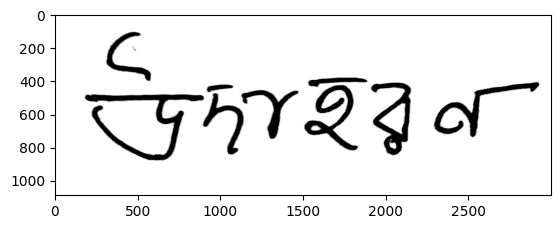

3000 1250
ইলক্ট্রাক্ট্রা
The closest word is 'কনট্রাকটর'


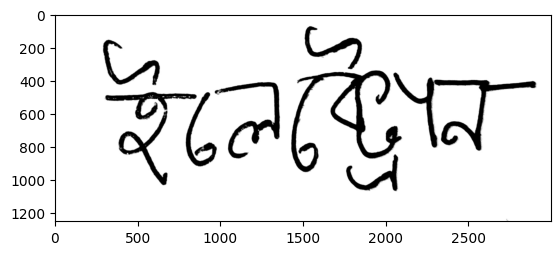

3000 2205
রাষ্ট্রীয়
Words similar to 'রাষ্ট্রীয়':রাষ্ট্রীয়


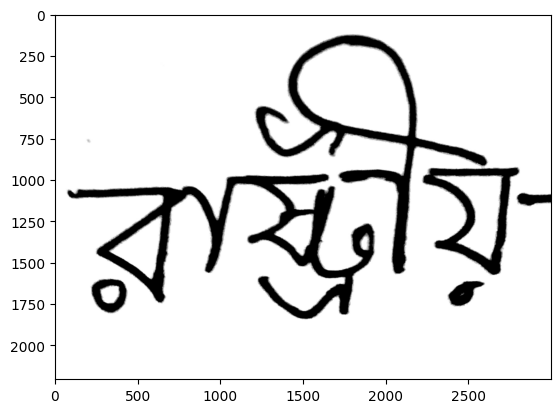

3000 731
অকালকুষ্ফন্ড
The closest word is 'অকালকুষ্মাণ্ড'


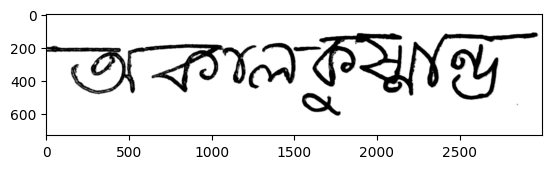

3000 939
সজ্জর্মিন্ডল
The closest word is 'সপ্তর্ষিমণ্ডল'


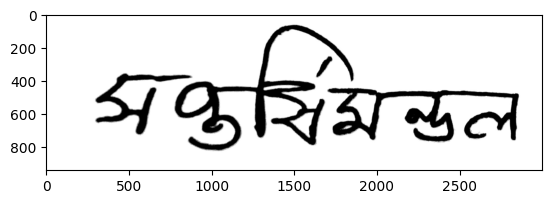

3000 1127
ইলেক্ট্রোর্ন
The closest word is 'ইলেকট্রন'


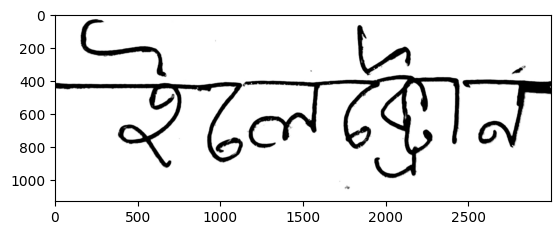

3000 1019
হাতের
The closest word is 'হাতেকরা'


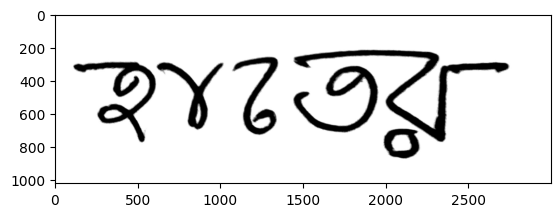

3000 931
মহাকাশ
Words similar to 'মহাকাশ':মহাকাশ


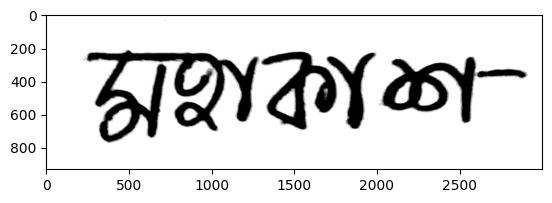

3000 2098
টেস্ট
Words similar to 'টেস্ট':টেস্ট


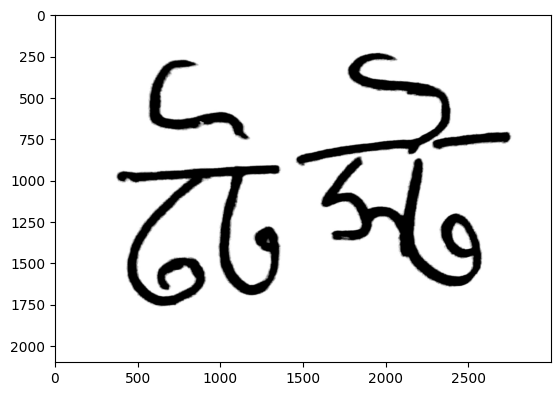

In [23]:
from PIL import Image, ImageOps
import os
import random
import matplotlib.pyplot as plt

# Path to the demo folder
demo_folder_path = 'handw_s_demo'

# Get a list of all files in the demo folder
all_files = os.listdir(demo_folder_path)

# Randomly select 16 files from the list
selected_files = random.sample(all_files, 9)

# Iterate over the selected files
for filename in selected_files:
    # Construct the full path to the image
    image_path = os.path.join(demo_folder_path, filename)

    # Open the image
    image = Image.open(image_path)
    
    width, height = image.size
    print(width, height)
    # Process image patches (assuming image_patch and detect functions are defined elsewhere)
    patches = image_patch(image_path, width, height, 'handw_s_demo_sorted_annotations.csv')
    detect(patches=patches)
